## DTSA-5511 Final Project

Github Repository: 


### Predicting Rainfall and Amount in Australia

 Weather forecasting is the application of science and technology to predict the conditions of the atmosphere for a given location and time. People have attempted to predict the weather for over centuries. As a meteorologist, I have used weather forecast models in the past to predict rainfall. Due to the high variability in rainfall patterns, data inefficiency, the absence of records, it is quite challenging to get a accurate rainfall prediction.

 In this project, the goal is to explore the use of Recurrent Neural Network (RNN) models to predict (1) whether it will rain tomorrow for a given location, and (2) the amount of rainfall for a given location using historical observations. For the first task, I will build a simple RNN model to predict binary rainfall labels (Rain: 1, No Rain: 0). For the second task, since we are using historical rainfall amount data to predict future rainfall amount, I will use Long short-term memory (LSTM) model to predict rainfall amount. Unlike typical weather forecast models which requires a lot of observations and often need significant computational resources, the amount of features we will be using will be limited, and the RNN models will be processed on my laptop.

 The data used in this project comes from an online data repository, Kaggle: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package. According to Kaggle description, the original data source is as follows:
 Data source: http://www.bom.gov.au/climate/dwo/ and http://www.bom.gov.au/climate/data.
 Copyright Commonwealth of Australia 2010, Bureau of Meteorology.

 The dataset consists of weather observations from numerous weather stations across Australia. More details of the data will be discussed in the EDA Analysis section.

### Import necessary libraries

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kaggle
import os
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import datetime

In [291]:
cwd = os.getcwd()
data = pd.read_csv(cwd+"/weatherAUS.csv", index_col=False)

### EDA Analysis and Data Cleaning

In [325]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [324]:
data.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [293]:
data.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

we can see that almost all features have nan values in them, thus we need to perform some data cleaning

In [294]:
# split the numerical and categorical feature columns
numerical_cols = data.select_dtypes(include='number').columns
categorical_cols = data.select_dtypes(exclude='number').columns

In [295]:
# the weather information should be grouped in terms of the location.
grouped = data.groupby('Location')

# Define function to fill NaN values for each group
def fill_nan_from_mean_mode(group):
    # Fill NaN values for numerical columns with mean
    group[numerical_cols] = group[numerical_cols].fillna(group[numerical_cols].mode().iloc[0])
    
    # Fill NaN values for categorical columns with mode
    group[categorical_cols] = group[categorical_cols].fillna(group[categorical_cols].mode().iloc[0])
    
    return group

# List of numerical and categorical columns excluding the 'Location_Column'
numerical_cols = data.select_dtypes(include='number').columns
categorical_cols = data.select_dtypes(exclude='number').columns

# Apply the fill_nan function to each group
df = grouped.apply(fill_nan_from_mean_mode)

In [296]:
# check if there are remaining nans
df.isnull().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation      45511
Sunshine         53169
WindGustDir       6079
WindGustSpeed     6079
WindDir9am           0
WindDir3pm           0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am      12119
Pressure3pm      12119
Cloud9am         34967
Cloud3pm         34967
Temp9am              0
Temp3pm              0
RainToday            0
RainTomorrow         0
dtype: int64

In [297]:
# Fill remaining NaN values with mean of entire column
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
# Fill remaining NaN values in categorical columns with mode of entire column
for col in categorical_cols:
    mode_value = df[col].mode().iloc[0]
    df[col] = df[col].fillna(mode_value)


In [298]:
# now we can see that there is no remaining nan values in any feature.
df.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

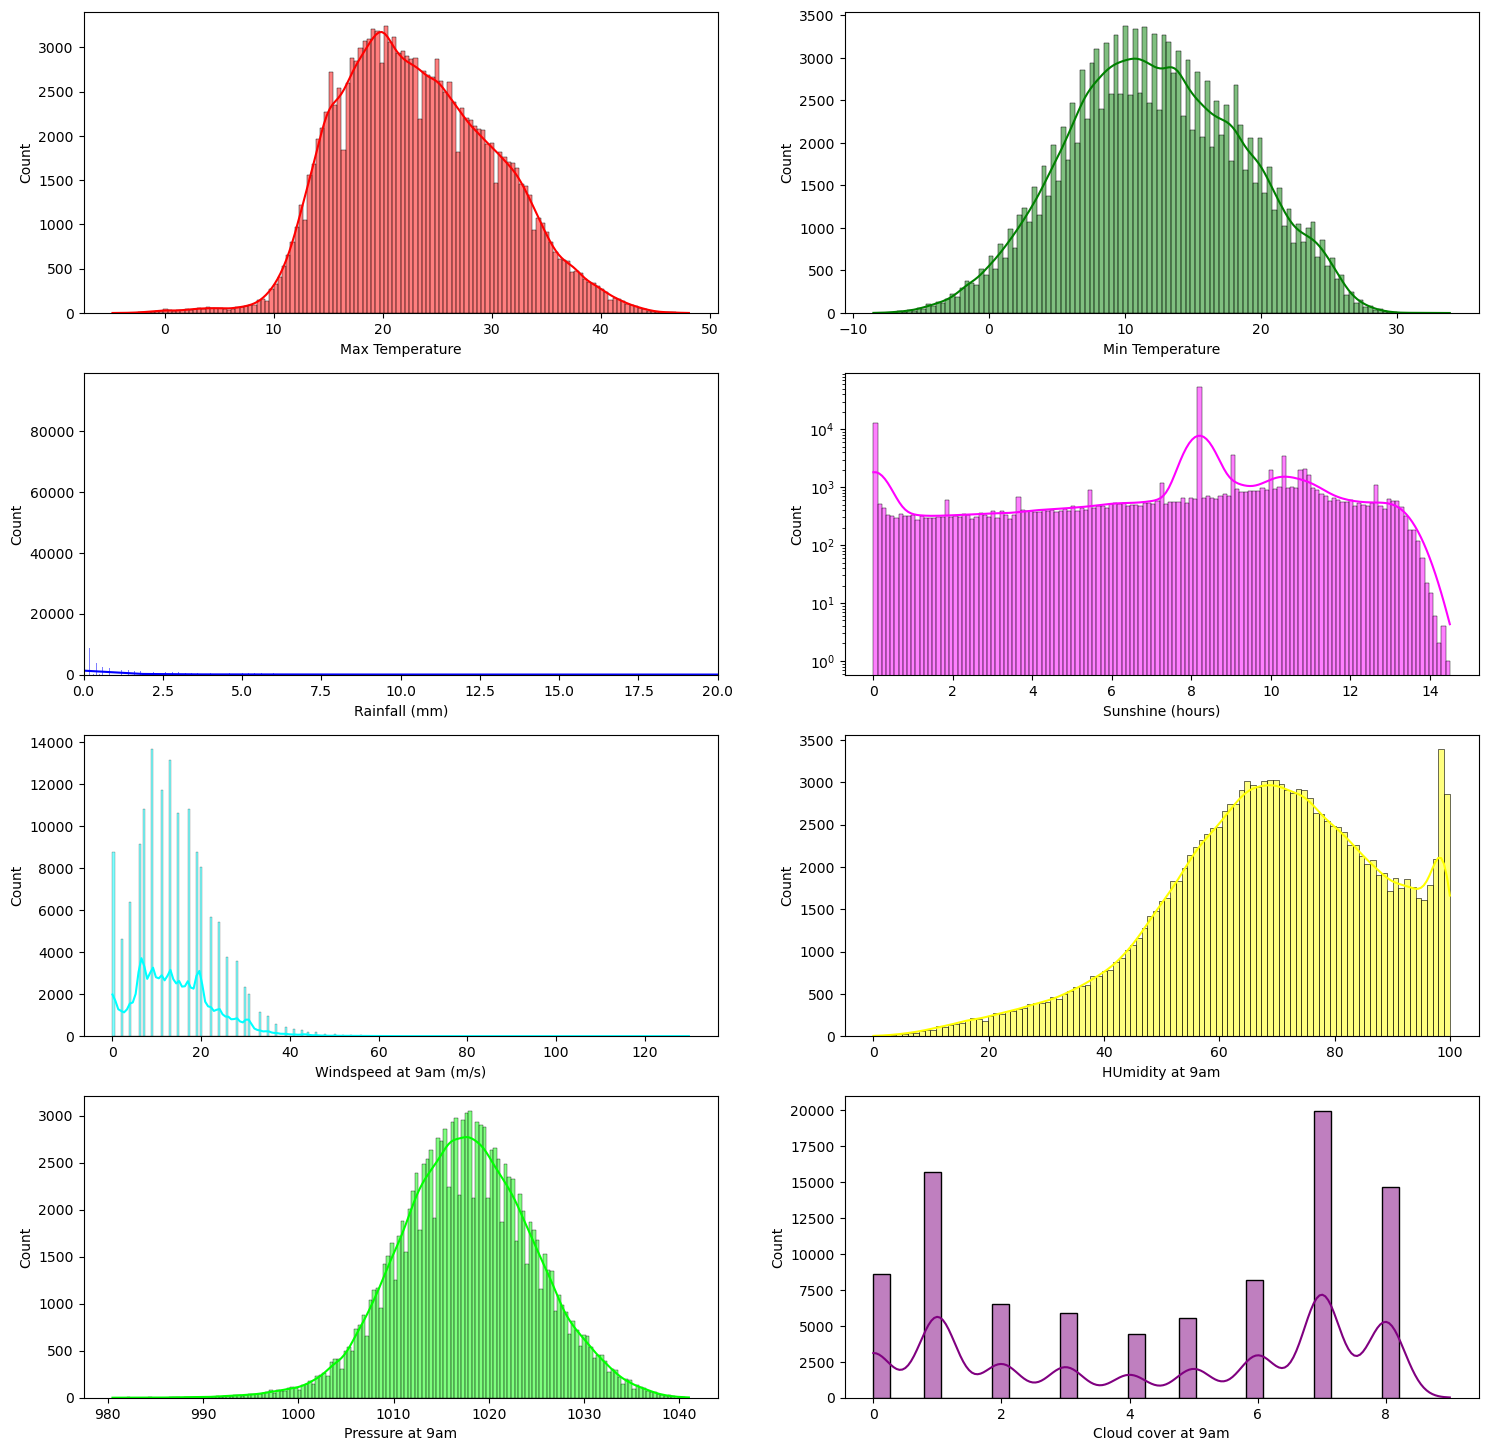

<Figure size 640x480 with 0 Axes>

In [16]:
fig, axes = plt.subplots(4, 2,figsize=(18,18))

#create histogram in each subplot

plt1 = sns.histplot(df['MaxTemp'],kde = True, color='red', ax=axes[0,0])
plt1.set_xlabel('Max Temperature')

plt2 = sns.histplot(df['MinTemp'],kde=True,color='green', ax=axes[0,1])
plt2.set_xlabel('Min Temperature')

plt3 = sns.histplot(df['Rainfall'],kde = True, color='blue', ax=axes[1,0])
plt3.set_xlabel('Rainfall (mm)')
plt3.set_xlim(0,20)


plt4 = sns.histplot(df['Sunshine'],kde=True,color='magenta', ax=axes[1,1], log_scale=(False, True))
plt4.set_xlabel('Sunshine (hours)')

plt5 = sns.histplot(data['WindSpeed9am'],kde=True,color='cyan', ax=axes[2,0])
plt5.set_xlabel('Windspeed at 9am (m/s)')

plt6 = sns.histplot(data['Humidity9am'],kde=True,color='yellow', ax=axes[2,1])
plt6.set_xlabel('HUmidity at 9am')

plt7 = sns.histplot(data['Pressure9am'],kde=True,color='lime', ax=axes[3,0])
plt7.set_xlabel('Pressure at 9am')

plt8 = sns.histplot(data['Cloud9am'],kde=True,color='purple', ax=axes[3,1])
plt8.set_xlabel('Cloud cover at 9am')

plt.show()
plt.tight_layout()

<Figure size 1600x800 with 0 Axes>

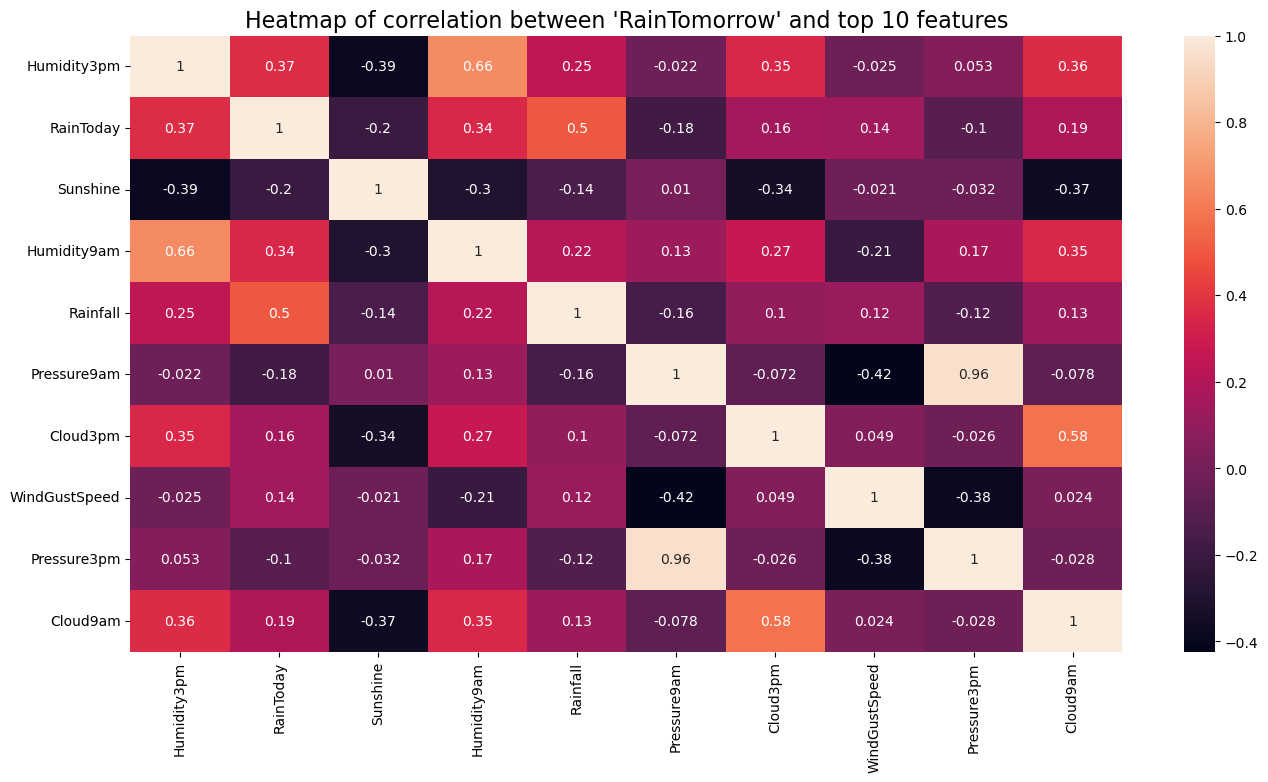

In [30]:
plt.figure(figsize=(16, 8))

correlation = df.corr() \
    ['RainTomorrow'].abs().sort_values(ascending=False) \
    [1:11]

res_data = df[correlation.index]

plt.figure(figsize=(16, 8))
sns.heatmap(res_data.corr(), annot=True)
plt.title("Heatmap of correlation between 'RainTomorrow' and top 10 features", fontsize=16)
plt.show()

In [176]:
df['RainTomorrow'].value_counts()

RainTomorrow
No     113583
Yes     31877
Name: count, dtype: int64

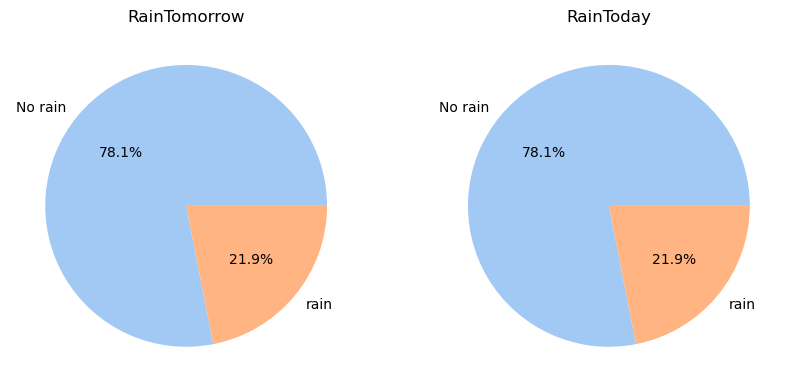

In [177]:
# Visualization of categorical data
fig, axs = plt.subplots(1, 2, figsize=(10,7))

axs[0].pie(df['RainTomorrow'].value_counts(), \
         labels=['No rain',  'rain'],autopct='%1.1f%%', \
        radius=1, colors=sns.color_palette('pastel')[0:2],
        textprops={'fontsize': 10})
axs[0].set_title('RainTomorrow')

axs[1].pie(df['RainToday'].value_counts(), \
          labels=['No rain',  'rain'],autopct='%1.1f%%', \
        radius=1, colors=sns.color_palette('pastel')[0:2],
        textprops={'fontsize': 10})
axs[1].set_title('RainToday')
plt.show()

### EDA Summary
From the EDA analysis, we can see that the dataset has 145460 entries, with multiple features having NaNs. From the histograms, we see that a lot of the features do not follow a normal distribution. From the pie charts, we also see that the target labels are imbalanced.


### Data preprocessing

we see that the target labels are skewed (imbalanced). Thus we will oversample to balance the labels.

In [26]:
# split the features with the target label.
X =df.drop(['RainTomorrow'],axis=1)
y = df.RainTomorrow
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X, y)

In [27]:
# For categorical variables, encode to different labels
cat_cols= [col for col in X_res.columns if X_res[col].dtype=='object']
encoder= LabelEncoder()

for col in cat_cols:
    X_res[col]= encoder.fit_transform(X_res[col])

X_res.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,243,0,8.8,15.7,5.0,1.6,2.6,7,48.0,12,...,15.0,92.0,67.0,1017.4,1017.7,6.0,6.0,13.5,14.9,1
1,244,0,12.7,15.8,0.8,1.4,7.8,12,35.0,11,...,15.0,75.0,52.0,1022.4,1022.6,6.0,6.0,13.7,15.5,0
2,245,0,6.2,15.1,0.0,1.8,2.1,13,20.0,5,...,11.0,81.0,56.0,1027.8,1026.5,6.0,6.0,9.3,13.9,0
3,246,0,5.3,15.9,0.0,1.4,8.0,5,30.0,5,...,13.0,71.0,46.0,1028.7,1025.6,6.0,6.0,10.2,15.3,0
4,247,0,9.8,15.4,0.0,1.4,0.9,3,30.0,5,...,9.0,56.0,67.0,1023.6,1020.2,6.0,6.0,11.3,13.8,0


In [29]:
X_res.describe().T

,count,mean,std,min,25%,50%,75%,max
Date,227166.0,1921.552063,885.861212,0.0,1157.0,1938.0,2694.0,3435.0
Location,227166.0,23.765159,14.161920,0.0,11.0,24.0,36.0,48.0
MinTemp,227166.0,12.553637,6.383307,-8.5,8.0,12.3,17.2,33.9
MaxTemp,227166.0,22.422617,7.115572,-4.8,17.2,21.7,27.4,48.1
Rainfall,227166.0,3.648196,11.073795,0.0,0.0,0.0,2.2,371.0
Evaporation,227166.0,4.668809,3.172364,0.0,3.0,4.2,5.4,145.0
Sunshine,227166.0,6.803797,3.535294,0.0,4.6,8.2,8.2,14.5
WindGustDir,227166.0,8.141302,4.636797,0.0,4.0,9.0,13.0,15.0
WindGustSpeed,227166.0,41.855533,14.250952,6.0,31.0,39.0,50.0,135.0
WindDir9am,227166.0,7.421410,4.443033,0.0,3.0,7.0,11.0,15.0


In [181]:
y_res.value_counts()

RainTomorrow
0    113583
1    113583
Name: count, dtype: int64

In [31]:
# select the 10 best features
from sklearn.feature_selection import SelectKBest, f_classif

skb= SelectKBest(score_func = f_classif, k=10)
X_new= skb.fit_transform(X_res, y_res)

X_new.shape

(227166, 10)

In [33]:
# as observed in the histograms, many features may not be normally distributed data,
# thus we will normalize the features

ss=StandardScaler()

X_train, X_test, y_train, y_test= train_test_split(X_new,y_res,test_size=0.2, stratify=y_res)
X_train= ss.fit_transform(X_train)
X_test= ss.transform(X_test)

### Part 1: Build Simple NN Model to predict Rain or No Rain

In [70]:
X_train.shape[0]

181732

In [50]:
# Simple Model
model= Sequential()

model.add(Dense(1024, activation='relu', input_dim= X_train.shape[1]))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [51]:
early_stopping= EarlyStopping(patience=15, monitor='val_loss')

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.legacy.Adam(learning_rate = 0.001))

In [54]:
history= model.fit(X_train, np.array(y_train), validation_split=0.1,batch_size=100, epochs=100, verbose=1)

Epoch 1/100
1636/1636 [==============================] - 7s 4ms/step - loss: 0.4596 - accuracy: 0.7810 - val_loss: 0.4523 - val_accuracy: 0.7845
Epoch 2/100
1636/1636 [==============================] - 6s 4ms/step - loss: 0.4478 - accuracy: 0.7871 - val_loss: 0.4473 - val_accuracy: 0.7857
Epoch 3/100
1636/1636 [==============================] - 7s 4ms/step - loss: 0.4412 - accuracy: 0.7910 - val_loss: 0.4420 - val_accuracy: 0.7871
Epoch 4/100
1636/1636 [==============================] - 7s 4ms/step - loss: 0.4363 - accuracy: 0.7931 - val_loss: 0.4397 - val_accuracy: 0.7918
Epoch 5/100
1636/1636 [==============================] - 7s 4ms/step - loss: 0.4312 - accuracy: 0.7961 - val_loss: 0.4331 - val_accuracy: 0.7955
Epoch 6/100
1636/1636 [==============================] - 6s 4ms/step - loss: 0.4255 - accuracy: 0.7993 - val_loss: 0.4298 - val_accuracy: 0.7964
Epoch 7/100
1636/1636 [==============================] - 7s 4ms/step - loss: 0.4198 - accuracy: 0.8027 - val_loss: 0.4274 - val_ac

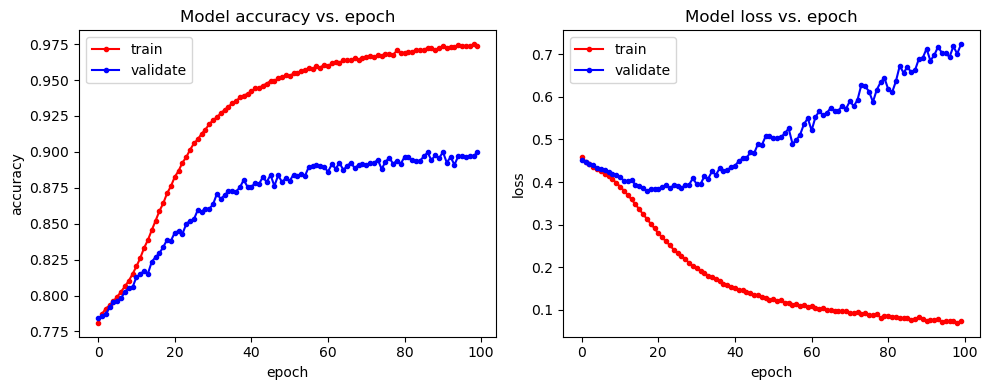

In [178]:
fig, ((ax1, ax2)) = plt.subplots(nrows= 1,ncols=2, figsize=(10,4))
ax1.plot(history.history['accuracy'], marker='.',color='red', label='train')
ax1.plot(history.history['val_accuracy'], marker='.',color='blue', label='validate')
ax1.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Model accuracy vs. epoch')

ax2.plot(history.history['loss'], marker='.',color='red', label='train')
ax2.plot(history.history['val_loss'], marker='.',color='blue', label='validate')
ax2.legend()
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model loss vs. epoch')
plt.tight_layout()
plt.tight_layout()

#### Summary for Simple Model

In [93]:
model.evaluate(X_train, y_train)

5680/5680 [==============================] - 7s 1ms/step - loss: 0.1199 - accuracy: 0.9686


[0.11986169219017029, 0.968574583530426]

In [94]:
model.evaluate(X_test,y_test)

1420/1420 [==============================] - 2s 1ms/step - loss: 0.6151 - accuracy: 0.8969


[0.6151255965232849, 0.8968833684921265]

In [95]:
predictions= model.predict(X_test)

1420/1420 [==============================] - 2s 1ms/step


In [96]:
predict=[]
for i in predictions:
    if i<0.5:
        predict.append(0)
    else:
        predict.append(1)

[0, 1, 1, 1, 0, 0, 1, 0, 1, 0]

In [249]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89     22717
           1       0.86      0.95      0.90     22717

    accuracy                           0.90     45434
   macro avg       0.90      0.90      0.90     45434
weighted avg       0.90      0.90      0.90     45434



### Part 2: Predict Rainfall amount using LSTM

In [167]:
df.Location.unique()

array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
       'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
       'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
       'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
       'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
       'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
       'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
       'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
       'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
       'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
      dtype=object)

In [307]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year-Mon'] = [x.strftime("%Y-%m") for x in df['Date']]

In [322]:
def LSTM_Prediction(dataframe, forecast_period,Location_str):
    test_df = dataframe.loc[dataframe['Location'] == Location_str]
    
    cat_cols= [col for col in test_df.columns if test_df[col].dtype=='object']
    for col in cat_cols:
        test_df[col]= encoder.fit_transform(test_df[col])
    
    mean_df = test_df.groupby(['Date']).mean()
    mean_df['RainfallPred'] = mean_df['Rainfall'].shift(-1)
    mean_df.drop(['Rainfall'], axis=1, inplace=True)

    mean_df.dropna(inplace=True)
    column_names = mean_df.columns

    # normalize the dataset     
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_mean_df = scaler.fit_transform(mean_df)

    # covnert to dataframe  
    scaled_mean_df = pd.DataFrame(scaled_mean_df, columns=column_names)

    # split into train and test sets 
    features = scaled_mean_df.values
    train = features[:forecast_period, :]
    test = features[forecast_period:, :]

    # split into input and outputs     
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]     
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # design network     
    lstm_model = Sequential()
    lstm_model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mae', optimizer='adam')
    # fit network     
    history = lstm_model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

    # plot history 
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], marker='.',color='red', label='train')
    plt.plot(history.history['val_loss'], marker='.',color='blue', label='validate')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Model loss vs. epoch')
    plt.tight_layout()
    plt.show()
    
    # make a prediction     
    yhat = lstm_model.predict(test_X)

    #to reverse MinMax reshape based on original shape     
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast     
    inv_yhat = np.concatenate((test_X[:, 0:], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]
    # invert scaling for actual     
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X[:,0:], test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]
    # calculate RMSE     
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_title_lstm = 'Test RMSE: %.3f' % rmse
    
    lstm_predictions = [np.nan for _ in range(0,len(train_X))]
    mean_df['LSTM Prediction'] = lstm_predictions + list(inv_yhat)
    mean_df[['RainfallPred', 'LSTM Prediction']].plot( figsize=(6,4), color=['red','blue'], title=rmse_title_lstm)
    plt.xlim(datetime.date(2016, 6, 1), datetime.date(2017, 7, 1))
    plt.show()

Epoch 1/20


/var/folders/mf/6p75cz_100v22mptnl137bwc0000gq/T/ipykernel_45506/880322037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[col]= encoder.fit_transform(test_df[col])
/var/folders/mf/6p75cz_100v22mptnl137bwc0000gq/T/ipykernel_45506/880322037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[col]= encoder.fit_transform(test_df[col])
/var/folders/mf/6p75cz_100v22mptnl137bwc0000gq/T/ipykernel_45506/880322037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

45/45 [==============================] - 2s 9ms/step - loss: 0.7130 - val_loss: 0.5518
Epoch 2/20
45/45 [==============================] - 0s 2ms/step - loss: 0.2402 - val_loss: 0.2014
Epoch 3/20
45/45 [==============================] - 0s 1ms/step - loss: 0.1473 - val_loss: 0.1308
Epoch 4/20
45/45 [==============================] - 0s 1ms/step - loss: 0.1064 - val_loss: 0.0847
Epoch 5/20
45/45 [==============================] - 0s 1ms/step - loss: 0.0804 - val_loss: 0.0553
Epoch 6/20
45/45 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0404
Epoch 7/20
45/45 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0349
Epoch 8/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0318
Epoch 9/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0302
Epoch 10/20
45/45 [==============================] - 0s 1ms/step - loss: 0.0467 - val_loss: 0.0299
Epoch 11/20
45/45 [===========

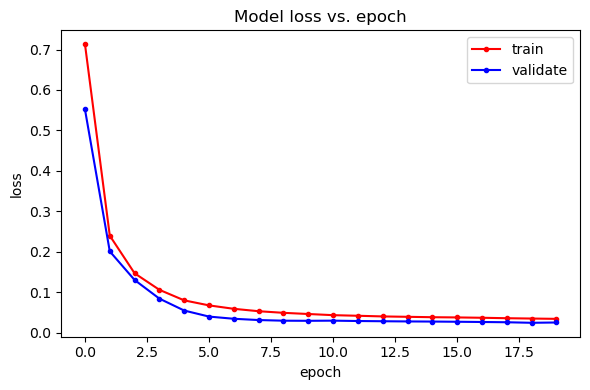

8/8 [==============================] - 0s 723us/step


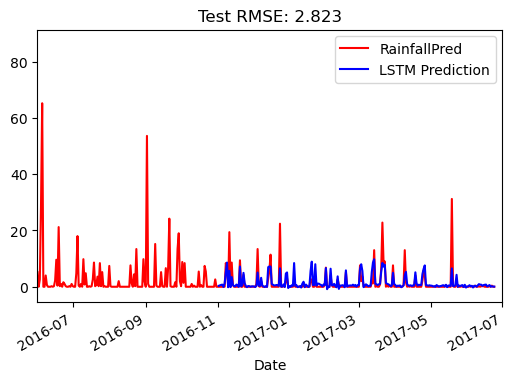

In [323]:
LSTM_Prediction(df, 3200,'Canberra')